In [482]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use('seaborn')

Questions to answer:
    - what variable is the most significant to predict the house prices?
    - how location affects house prices?
    - homes with a large lot vs homes with a large sqft of the home?
    - how does waterfront homes affect the price? (assumption: small waterfront homes are incredibly expensive)


### Loading the data & initial investigation

In [483]:
df = pd.read_csv('kc_house_data.csv')

In [484]:
type(df.waterfront.loc[0])

numpy.float64

In [485]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [487]:
#check for null values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

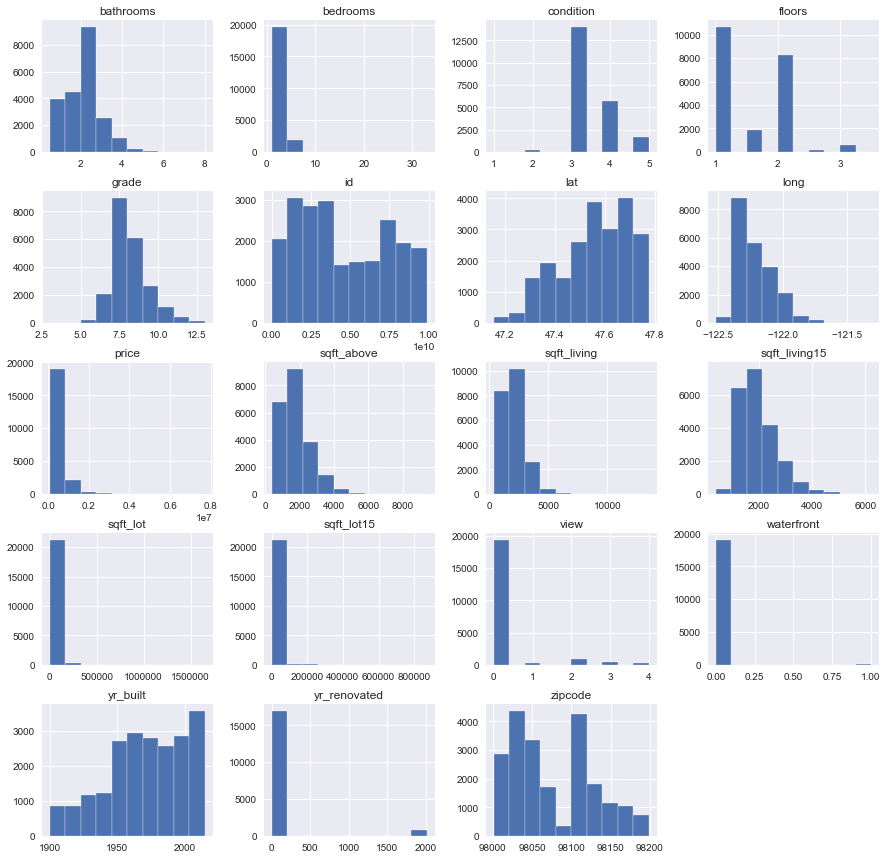

In [488]:
#look at the distribution of the variables
df.hist(figsize=(15, 15));

### Baseline for measuring regression metrics

In [489]:
price = df.price

In [490]:
mean_price = price.mean()
mean_price
#we will assume that the worst model is the mean price

sq_error = (price - mean_price)**2
mse = sq_error.mean()
rmse = np.sqrt(mse)
mae = abs(price - mean_price).mean()

In [491]:
#baseline metrics to compare with our model
print(mse, rmse, mae)

134953101375.57014 367359.63492954714 234028.17572404226


### Data cleaning

Initially, we removed lat and long variables thinking on working with just zipcodes

In [492]:
df = df.drop(['lat', 'long'], axis=1)

We assumed that 'view' is not relevant for house prices since it indicates if the house has been viewed

In [493]:
df = df.drop(['view'], axis=1)

In [494]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

Remove 'id' since it is not a predictor

In [495]:
df = df.drop(['id'], axis=1)

Dealing with year renovated column: the percentage of existing data on renovation year is too small compared to the size of data set: decided to drop the column for now

In [496]:
df = df.drop(['yr_renovated'], axis=1)

sqft basements needed to be converted to a float


In [497]:
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [498]:
#replaced '?' values with defference in sdft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']


In [499]:
#convert strings to floats
df.sqft_basement = df.sqft_basement.apply(lambda x: float(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(5), int64(10), object(1)
memory usage: 2.6+ MB


In [500]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [501]:
#check for correlations coefficients more than 0.75 in the dataframe
df.corr()
df.corr().applymap(lambda x: True if abs(x)>0.75 else False)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,True,True,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False


Make seaborn heatmap to check for multicollinearity

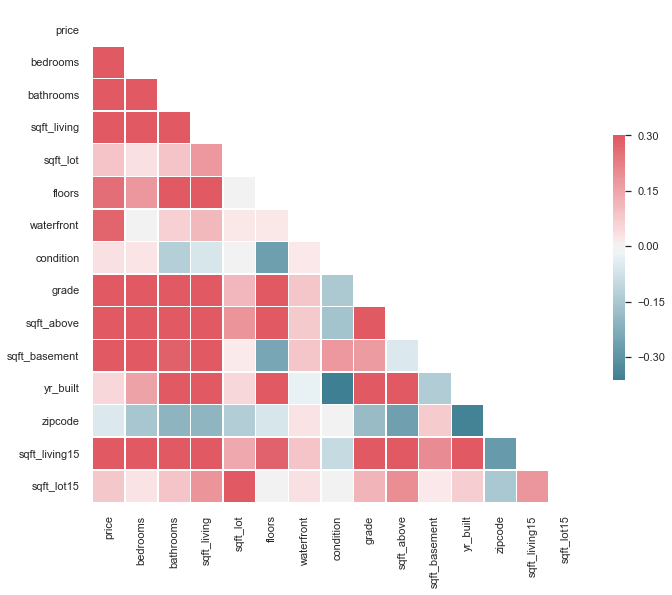

In [502]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


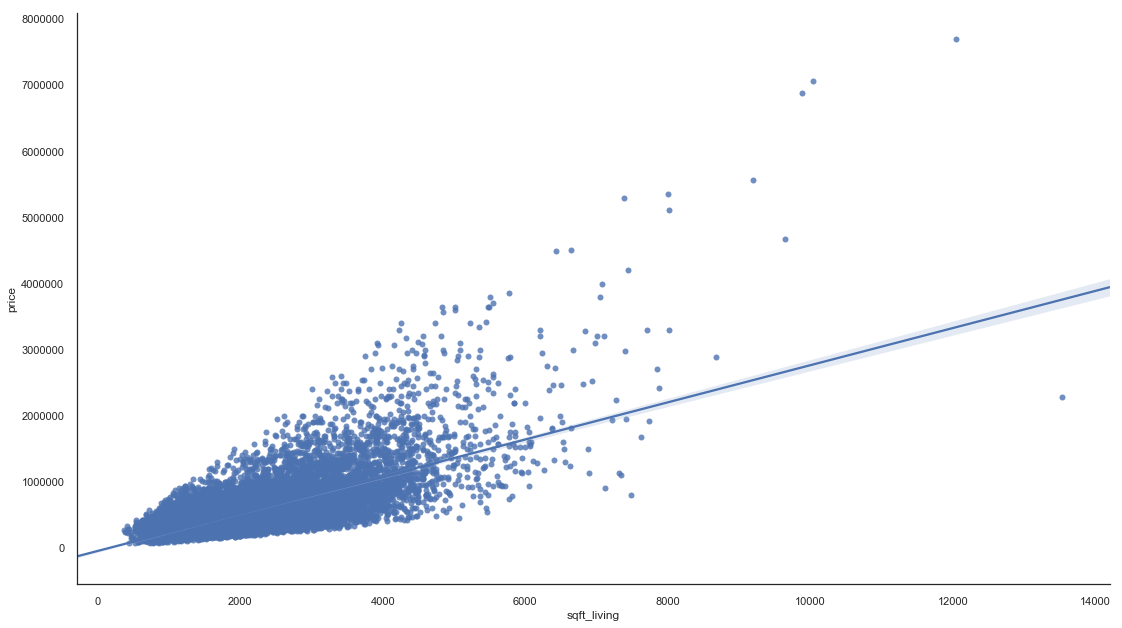

In [503]:
#visualize relationship between sqft_living and target variable
g = sns.regplot(df.sqft_living, df.price)
g.figure.set_size_inches(18.5, 10.5)
sns.despine()

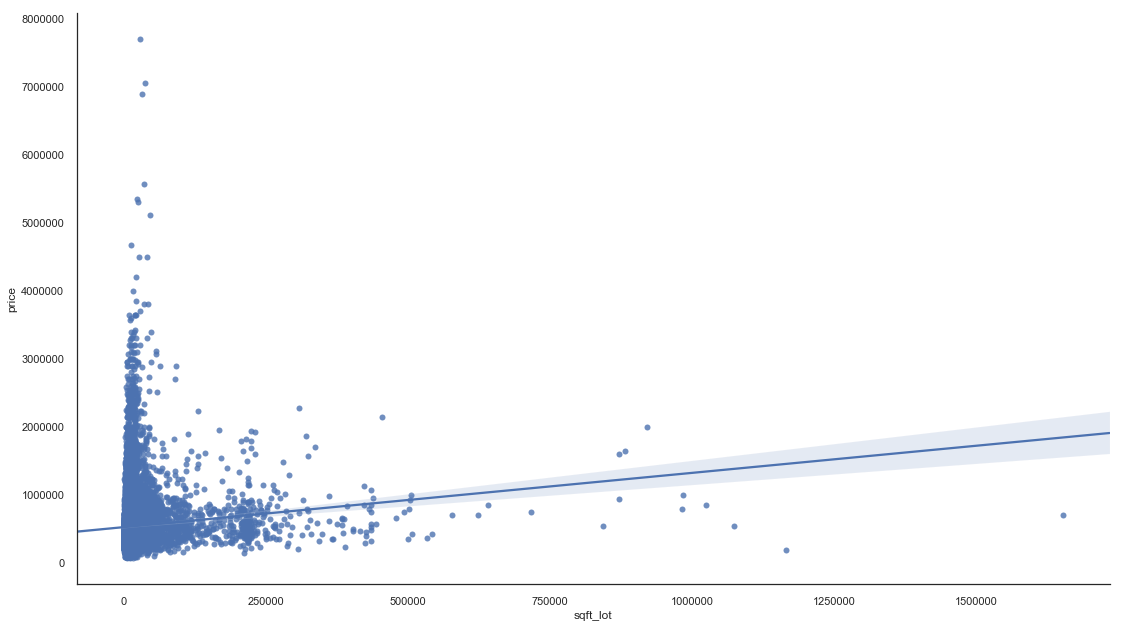

In [504]:
#visualize relationship between sqft_lot and target variable
g = sns.regplot(df.sqft_lot, df.price)
g.figure.set_size_inches(18.5, 10.5)
sns.despine()

it seems that size of the lot doesn't have this much of an effect on the price comparing with sqft of the house

### First model: linear regression based on just sqft_living

In [505]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

target = df.price
predictors = df.sqft_living
predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:06:45   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The obtained R squared explains only about 50% of the variation of the target price.

In [506]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt

def rmse(y_actual,y_predicted):
   return sqrt(mean_squared_error(y_actual, y_predicted))

def mae(y_actual,y_predicted):
   return abs(y_actual-y_predicted).mean()

model = LinearRegression()
y = df.price
X = pd.DataFrame(df['sqft_living'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(rmse(y_test,y_pred))
print(mae(y_test,y_pred))


249948.33791722127
171501.74619931992


RMSE value is 249948.33791722127
MAE value is 171501.7461993202

In [507]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-173897.1368561744


MAE through cross-validation is 173897.1368561744

### Clearly, one variable analysis is not enough to predict the price, as there may be other significant variables.
### We will proceed to further cleaning the data to see correlations more clearly

Convert floors variable into intereger:

In [508]:
df.floors = df.floors.apply(lambda x: int(x))

Now we will deal with waterfront that also has null values

In [509]:
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [510]:
df.waterfront.isna().sum()

2376

We decided to apply dummy variable for waterfont column removing those values where the data is missing

In [511]:
waterfront_dummies = pd.get_dummies(df["waterfront"], prefix="WF", )
df = df.drop(["waterfront"], axis=1)
df = pd.concat([df, waterfront_dummies], axis=1)

In [512]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,WF_0.0,WF_1.0
0,10/13/2014,221900.0,3,1.00,1180,5650,1,3,7,1180,0.0,1955,98178,1340,5650,0,0
1,12/9/2014,538000.0,3,2.25,2570,7242,2,3,7,2170,400.0,1951,98125,1690,7639,1,0
2,2/25/2015,180000.0,2,1.00,770,10000,1,3,6,770,0.0,1933,98028,2720,8062,1,0
3,12/9/2014,604000.0,4,3.00,1960,5000,1,5,7,1050,910.0,1965,98136,1360,5000,1,0
4,2/18/2015,510000.0,3,2.00,1680,8080,1,3,8,1680,0.0,1987,98074,1800,7503,1,0


Next step - convert year built to how many years ago built

In [513]:
df['age'] = 2019 - df['yr_built']

In [514]:
df = df.drop(["yr_built"], axis=1)

Last thing in preliminary data cleaning would be converting date to datetime instead of having it as an object. then we will see how many years ago it was sold

In [515]:
df.date = pd.to_datetime(df.date)
df['sold_y_ago'] = df.date.apply(lambda x: 2019 - x.year)
df = df.drop(["date"], axis=1)

In [516]:
df['sold_y_ago'].value_counts()

5    14622
4     6975
Name: sold_y_ago, dtype: int64

it looks like there is only 2 values, that can be converted to dummie variables

In [517]:
sold_y_ago_dummies = pd.get_dummies(df["sold_y_ago"], prefix="SOLD_AGO", )
df = df.drop(["sold_y_ago"], axis=1)
df = pd.concat([df, sold_y_ago_dummies], axis=1)

### Correlations and multicollinearity

After the data seems to be cleaned up, we will look at the distributions of the variables

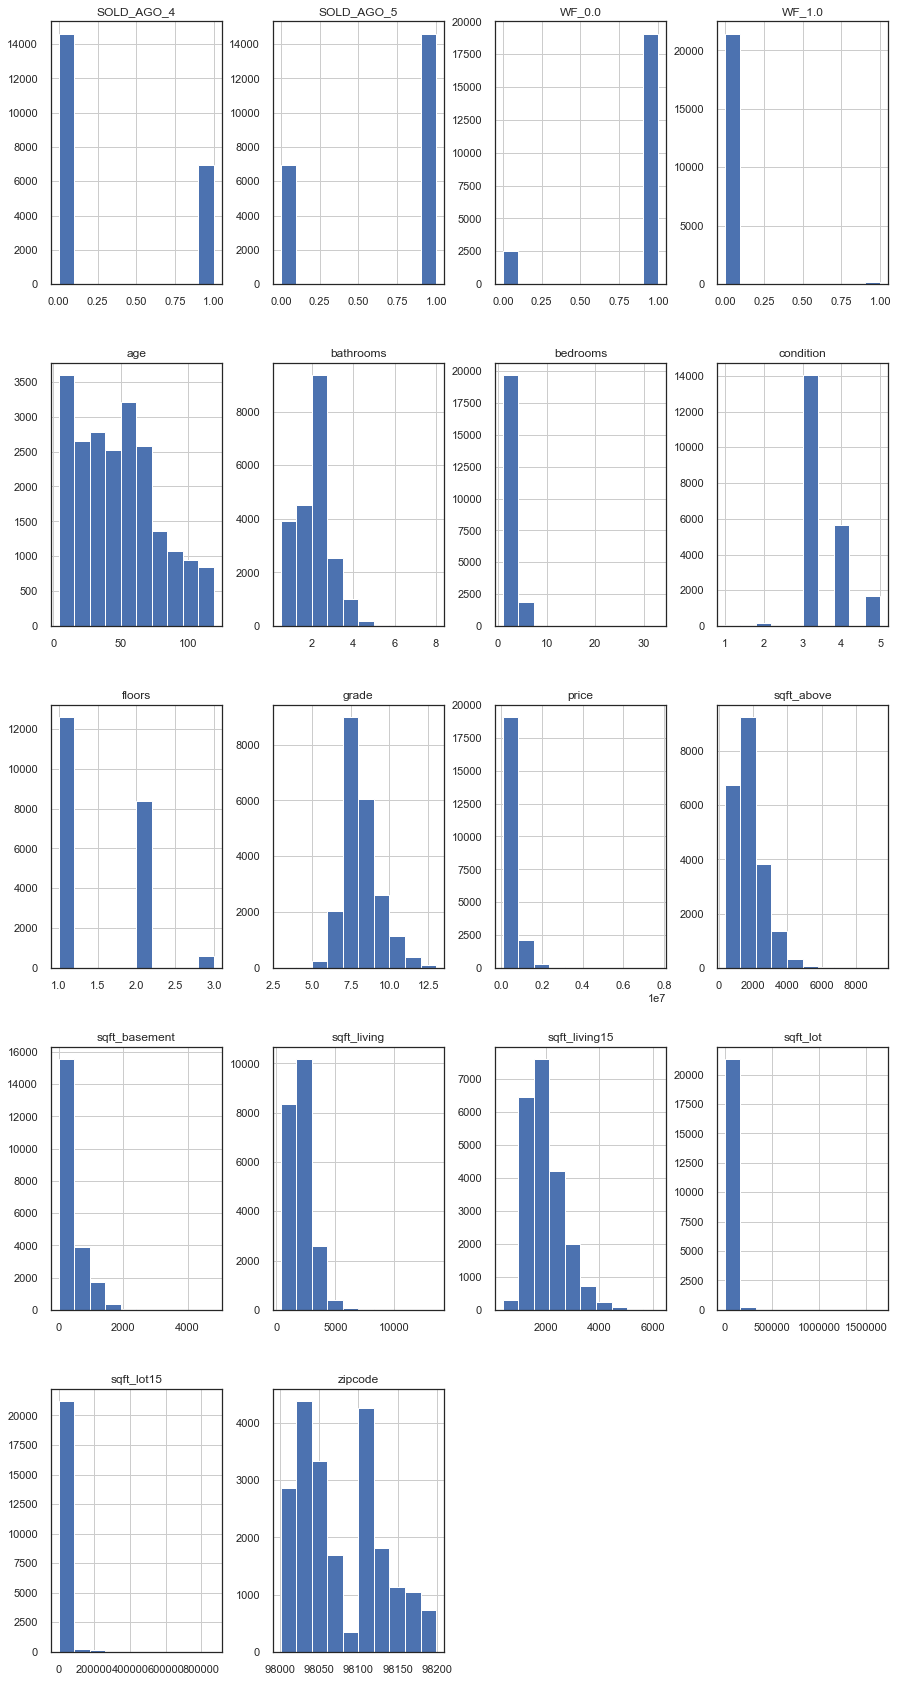

In [518]:
df.hist(figsize=(15,30));

After cleaning the data we will see if correlations and heatmap table looks any more clear

In [519]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,WF_0.0,WF_1.0,age,SOLD_AGO_4,SOLD_AGO_5
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.237264,0.036056,0.667951,0.605368,0.323799,-0.053402,0.585241,0.082845,-0.057305,0.264306,-0.053953,0.003727,-0.003727
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.158065,0.026496,0.356563,0.479386,0.302808,-0.154092,0.393406,0.030690,0.004858,-0.002127,-0.155670,-0.009949,0.009949
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.520922,-0.126479,0.665838,0.686668,0.283440,-0.204786,0.569884,0.088303,-0.011744,0.063629,-0.507173,-0.026577,0.026577
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353372,-0.059445,0.762779,0.876448,0.435130,-0.199802,0.756402,0.184342,-0.020362,0.104637,-0.318152,-0.029014,0.029014
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.008603,-0.008830,0.114731,0.184139,0.015418,-0.129586,0.144763,0.718204,-0.007191,0.021459,-0.052946,0.005628,-0.005628
floors,0.237264,0.158065,0.520922,0.353372,-0.008603,1.000000,-0.293463,0.473273,0.518037,-0.235793,-0.097146,0.296797,-0.012766,0.002295,0.018321,-0.578549,-0.019523,0.019523
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.293463,1.000000,-0.146896,-0.158904,0.173849,0.002888,-0.093072,-0.003126,-0.003639,0.016648,0.361592,-0.045898,0.045898
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.473273,-0.146896,1.000000,0.756073,0.168220,-0.185771,0.713867,0.120981,-0.013732,0.082818,-0.447865,-0.030635,0.030635
sqft_above,0.605368,0.479386,0.686668,0.876448,0.184139,0.518037,-0.158904,0.756073,1.000000,-0.052156,-0.261570,0.731767,0.195077,-0.009043,0.071778,-0.424037,-0.023782,0.023782
sqft_basement,0.323799,0.302808,0.283440,0.435130,0.015418,-0.235793,0.173849,0.168220,-0.052156,1.000000,0.074725,0.200443,0.017550,-0.025322,0.082800,0.133064,-0.015706,0.015706


In [520]:
df.corr().applymap(lambda x: True if abs(x)>0.8 else False)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,WF_0.0,WF_1.0,age,SOLD_AGO_4,SOLD_AGO_5
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


### New model

Based on correlation between variables (multicollinearity) we decided to drop those variables that have correlation levels greater than o.8 which is sqft_above/sqft_living. We removed sqft_above, as sqft_living had greater correlation coefficient with target variable price.

After that we proceeded to choose variables for our model based on correlation level with price. We chose to include those where correlation index is greater than 0.1: bedrooms, bathrooms, sqft_living, floors, grade, sqft_basement, sqft_living15, WF_1.0.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


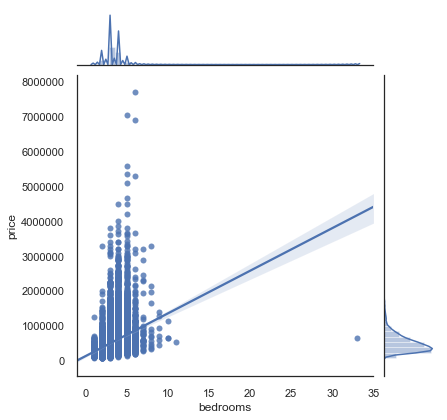

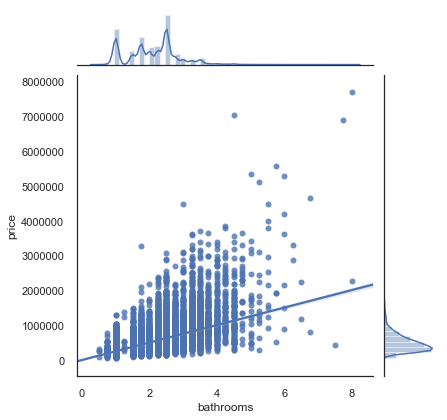

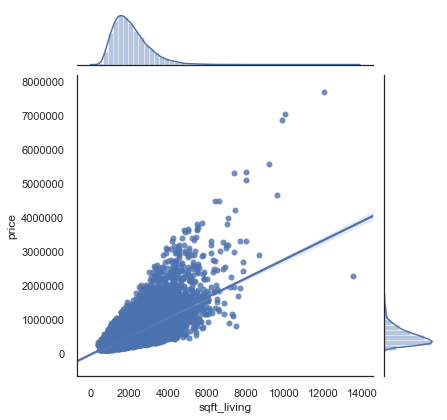

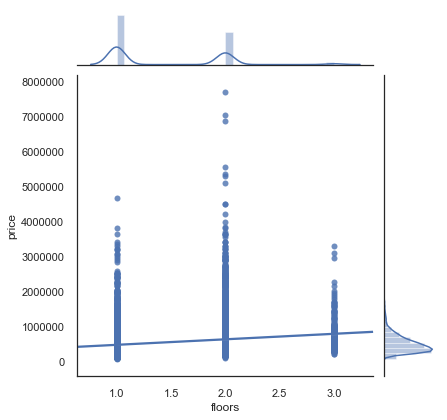

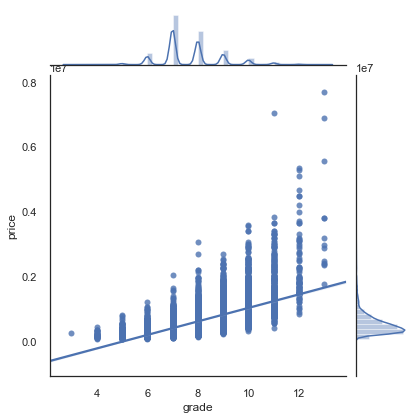

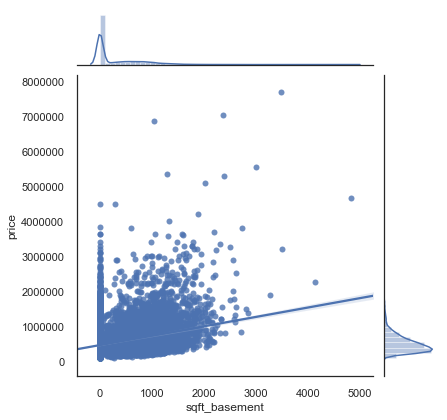

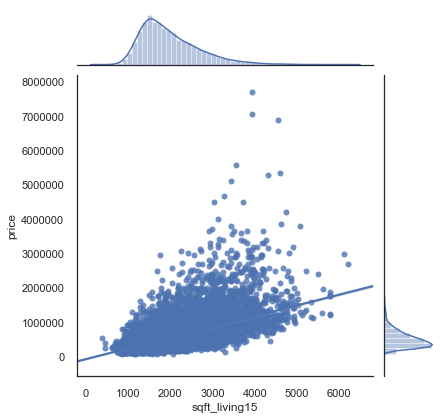

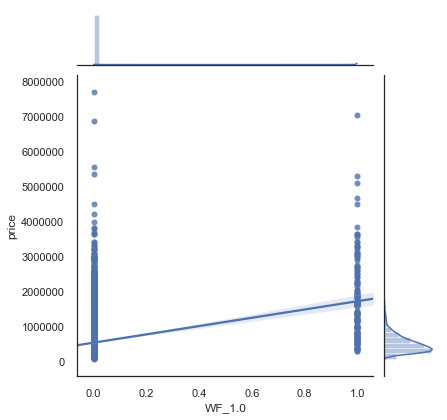

In [521]:
predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_basement', 
             'sqft_living15', 'WF_1.0']

#plotting selected variables
for col in predictors:
    sns.jointplot(col,'price',data=df,kind='reg')
    plt.show()

After creating jointplots for these variables, there seems to be a significant relationship between the target variable and variables sqft_living15, bathrooms, sqft_living and grade.

In [522]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

target = df.price
predictors = df[['bedrooms','bathrooms','sqft_living','floors','sqft_basement','sqft_living15','WF_1.0']]

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     3731.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:17   Log-Likelihood:            -2.9883e+05
No. Observations:               21597   AIC:                         5.977e+05
Df Residuals:                   21589   BIC:                         5.977e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.206e+04   8162.934      2.702      0.007    6057.119    3.81e+04
bedrooms      -5.061e+04   2283.157    -22.166      0.000   -5.51e+04   -4.61e+04
bathrooms      1.436e+04   3771.851      3.808      0.000    6969.639    2.18e+04
sqft_living     250.8666      4.046     62.009      0.000     242.937     258.796
floors        -7287.2392   4101.204     -1.777      0.076   -1.53e+04     751.424
sqft_basement    31.9187      4.934      6.469      0.000      22.248      41.589
sqft_living15    66.6248      3.863     17.245      0.000      59.052      74.197
WF_1.0          8.21e+05   2.07e+04     39.610      0.000     7.8e+05    8.62e+05
==============================================================================
Omnibus:                    13844.450   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           503736.197
Skew:                           2.549   Prob(JB):                         0.00
Kurtosis:                      26.104   Cond. No.                     3.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We decided to remove Floors because the p value was higher than 0.05

In [523]:
target = df.price
predictors = df[['bedrooms','bathrooms','sqft_living','sqft_basement','sqft_living15','WF_1.0']]

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     4352.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:17   Log-Likelihood:            -2.9883e+05
No. Observations:               21597   AIC:                         5.977e+05
Df Residuals:                   21590   BIC:                         5.977e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.634e+04   7501.962      2.178      0.029    1633.611     3.1e+04
bedrooms      -5.015e+04   2268.823    -22.106      0.000   -5.46e+04   -4.57e+04
bathrooms      1.142e+04   3389.509      3.370      0.001    4778.251    1.81e+04
sqft_living     249.7970      4.001     62.437      0.000     241.955     257.639
sqft_basement    36.0464      4.353      8.281      0.000      27.514      44.579
sqft_living15    67.0720      3.855     17.397      0.000      59.515      74.629
WF_1.0         8.209e+05   2.07e+04     39.606      0.000     7.8e+05    8.62e+05
==============================================================================
Omnibus:                    13887.222   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           510166.990
Skew:                           2.557   Prob(JB):                         0.00
Kurtosis:                      26.255   Cond. No.                     3.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [524]:
#Checking metrics for this model

def mae(y_actual,y_predicted):
   return abs(y_actual-y_predicted).mean()

model = LinearRegression()
y = df.price
X = predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

232820.2276880657
162673.48697656958


In [525]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-166196.07703615504


We will try to improve the model by normalizing certain features

We tried to perform log normalization on continuous distributions to see if it will improve R squared. It did not, although the p-values are 0s. MinMax transformation did not give any results

In [526]:
def normalize(df_column):
   return (df_column - df_column.mean())/df_column.std()

Standardizing features did not appear to have a noticible effect on the model

### Next model
### next step - create more dummie variables for columns where there are few numerical values 

In [527]:
floors_dummies = pd.get_dummies(df['floors'], prefix='FL_NUM')
predictors = pd.concat([predictors, floors_dummies], axis=1)

In [528]:
predictors.head()

,bedrooms,bathrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3
0,3,1.00,1180,0.0,1340,0,1,0,0
1,3,2.25,2570,400.0,1690,0,0,1,0
2,2,1.00,770,0.0,2720,0,1,0,0
3,4,3.00,1960,910.0,1360,0,1,0,0
4,3,2.00,1680,0.0,1800,0,1,0,0


In [529]:
target = df.price

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     3343.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:17   Log-Likelihood:            -2.9869e+05
No. Observations:               21597   AIC:                         5.974e+05
Df Residuals:                   21588   BIC:                         5.975e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6626.1374   6711.187      0.987      0.323   -6528.285    1.98e+04
bedrooms      -4.947e+04   2269.390    -21.797      0.000   -5.39e+04    -4.5e+04
bathrooms      1.875e+04   3756.488      4.992      0.000    1.14e+04    2.61e+04
sqft_living     259.9504      4.055     64.098      0.000     252.001     267.900
sqft_basement    12.7805      5.032      2.540      0.011       2.917      22.644
sqft_living15    72.0262      3.852     18.700      0.000      64.477      79.576
WF_1.0         8.154e+05   2.06e+04     39.593      0.000    7.75e+05    8.56e+05
FL_NUM_1      -1.497e+04   3684.363     -4.064      0.000   -2.22e+04   -7752.750
FL_NUM_2      -6.706e+04   4666.089    -14.371      0.000   -7.62e+04   -5.79e+04
FL_NUM_3       8.866e+04   7932.854     11.176      0.000    7.31e+04    1.04e+05
==============================================================================
Omnibus:                    13776.661   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           496175.329
Skew:                           2.533   Prob(JB):                         0.00
Kurtosis:                      25.928   Cond. No.                     8.59e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.79e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [530]:
#Checking metrics for this model

def mae(y_actual,y_predicted):
   return abs(y_actual-y_predicted).mean()

model = LinearRegression()
y = df.price
X = predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

231400.18511375246
161730.1960812899


In [531]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-164958.7810812438


### New model incorporating locations

In order to account for variability for the location, we decided to see how far from Seattle downtown are the locations of the houses. Seattle downtown location established as coordinates 47.6062° N, 122.3321° W

In [532]:
#testing geopy distance calculator

from geopy.distance import geodesic
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(geodesic(newport_ri, cleveland_oh).miles)

538.3904453677204


In [533]:
df_complete = pd.read_csv('kc_house_data.csv')

In [534]:
predictors['lat'] = df_complete['lat']

In [535]:
predictors['long'] = df_complete['long']

In [536]:
predictors.head()

,bedrooms,bathrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,lat,long
0,3,1.00,1180,0.0,1340,0,1,0,0,47.5112,-122.257
1,3,2.25,2570,400.0,1690,0,0,1,0,47.7210,-122.319
2,2,1.00,770,0.0,2720,0,1,0,0,47.7379,-122.233
3,4,3.00,1960,910.0,1360,0,1,0,0,47.5208,-122.393
4,3,2.00,1680,0.0,1800,0,1,0,0,47.6168,-122.045


In [537]:
seattle_downtown = (47.6062, -122.3321)

In [538]:
predictors['mi_from_downtown'] = list(map(lambda x,y: geodesic(seattle_downtown,(x,y)).miles, predictors['lat'],predictors['long']))



In [539]:
predictors.head()

,bedrooms,bathrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,lat,long,mi_from_downtown
0,3,1.00,1180,0.0,1340,0,1,0,0,47.5112,-122.257,7.443664
1,3,2.25,2570,400.0,1690,0,0,1,0,47.7210,-122.319,7.954648
2,2,1.00,770,0.0,2720,0,1,0,0,47.7379,-122.233,10.206394
3,4,3.00,1960,910.0,1360,0,1,0,0,47.5208,-122.393,6.551165
4,3,2.00,1680,0.0,1800,0,1,0,0,47.6168,-122.045,13.432452


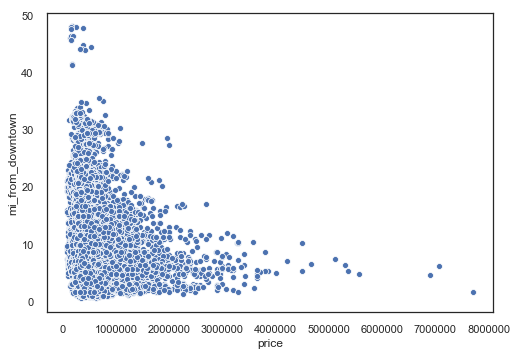

In [540]:
sns.scatterplot(df.price, predictors.mi_from_downtown)

In [541]:
predictors = predictors.drop(['lat', 'long'], axis=1)
predictors.head()

,bedrooms,bathrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,mi_from_downtown
0,3,1.00,1180,0.0,1340,0,1,0,0,7.443664
1,3,2.25,2570,400.0,1690,0,0,1,0,7.954648
2,2,1.00,770,0.0,2720,0,1,0,0,10.206394
3,4,3.00,1960,910.0,1360,0,1,0,0,6.551165
4,3,2.00,1680,0.0,1800,0,1,0,0,13.432452


incorporating mi_from_seattle into our model

In [542]:
target = df.price

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     4910.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:25   Log-Likelihood:            -2.9536e+05
No. Observations:               21597   AIC:                         5.907e+05
Df Residuals:                   21587   BIC:                         5.908e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                 9e+04   5829.642     15.438      0.000    7.86e+04    1.01e+05
bedrooms         -4.608e+04   1945.637    -23.684      0.000   -4.99e+04   -4.23e+04
bathrooms         3.774e+04   3227.135     11.695      0.000    3.14e+04    4.41e+04
sqft_living        271.3335      3.479     78.000      0.000     264.515     278.152
sqft_basement      -83.4015      4.449    -18.747      0.000     -92.121     -74.682
sqft_living15       86.9829      3.306     26.311      0.000      80.503      93.463
WF_1.0            8.032e+05   1.77e+04     45.499      0.000    7.69e+05    8.38e+05
FL_NUM_1          6.831e+04   3296.006     20.724      0.000    6.18e+04    7.48e+04
FL_NUM_2         -1381.6375   4068.229     -0.340      0.734   -9355.667    6592.392
FL_NUM_3          2.307e+04   6840.280      3.373      0.001    9665.657    3.65e+04
mi_from_downtown -2.025e+04    229.337    -88.287      0.000   -2.07e+04   -1.98e+04
==============================================================================
Omnibus:                    16110.435   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1019453.252
Skew:                           3.017   Prob(JB):                         0.00
Kurtosis:                      36.113   Cond. No.                     8.59e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.79e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [543]:
#Checking metrics for this model

def mae(y_actual,y_predicted):
   return abs(y_actual-y_predicted).mean()

model = LinearRegression()
y = df.price
X = predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

195179.5676449265
134016.02435956328


In [544]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-136510.69514905842


the R squared and other metrics improved significantly. we will now do data transformations of our new variable: Log transformation
    

In [545]:
predictors['mi_from_downtown_log'] = np.log(predictors['mi_from_downtown'])
predictors.head()

,bedrooms,bathrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,mi_from_downtown,mi_from_downtown_log
0,3,1.00,1180,0.0,1340,0,1,0,0,7.443664,2.007363
1,3,2.25,2570,400.0,1690,0,0,1,0,7.954648,2.073756
2,2,1.00,770,0.0,2720,0,1,0,0,10.206394,2.323014
3,4,3.00,1960,910.0,1360,0,1,0,0,6.551165,1.879643
4,3,2.00,1680,0.0,1800,0,1,0,0,13.432452,2.597674


doesn't seem to improve the distribution either. Will try standard scaler as other variables are standardized

### try model with log normalized distance: (besr r squared so far)

In [546]:
new_predictors = predictors.drop(['mi_from_downtown'], axis=1)

In [547]:
target = df.price

predictors_int = sm.add_constant(new_predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     5252.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:25   Log-Likelihood:            -2.9487e+05
No. Observations:               21597   AIC:                         5.898e+05
Df Residuals:                   21587   BIC:                         5.898e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.469e+05   6157.205     40.096      0.000    2.35e+05    2.59e+05
bedrooms             -4.178e+04   1903.023    -21.957      0.000   -4.55e+04   -3.81e+04
bathrooms             3.692e+04   3152.961     11.710      0.000    3.07e+04    4.31e+04
sqft_living            274.2311      3.401     80.632      0.000     267.565     280.897
sqft_basement          -96.5894      4.368    -22.113      0.000    -105.151     -88.028
sqft_living15           98.4911      3.239     30.409      0.000      92.143     104.839
WF_1.0                8.254e+05   1.73e+04     47.836      0.000    7.92e+05    8.59e+05
FL_NUM_1              1.366e+05   3469.010     39.374      0.000     1.3e+05    1.43e+05
FL_NUM_2              4.702e+04   4086.843     11.506      0.000     3.9e+04     5.5e+04
FL_NUM_3              6.327e+04   6651.557      9.512      0.000    5.02e+04    7.63e+04
mi_from_downtown_log -2.165e+05   2260.675    -95.749      0.000   -2.21e+05   -2.12e+05
==============================================================================
Omnibus:                    15769.868   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1037517.940
Skew:                           2.901   Prob(JB):                         0.00
Kurtosis:                      36.456   Cond. No.                     8.59e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.79e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [548]:
#Checking metrics for this model

def mae(y_actual,y_predicted):
   return abs(y_actual-y_predicted).mean()

model = LinearRegression()
y = df.price
X = new_predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

190392.81067174108
131342.48367746302


In [549]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-134234.81105669797


### New model with binning with number of floors

In [550]:
bins = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

for i in range (1, 6):
    new_predictors["binned_bath_num"] = pd.cut(new_predictors['bathrooms'], 5, labels=bins)    

In [551]:
new_predictors = new_predictors.drop(['bathrooms'], axis=1)

In [552]:
new_predictors.head()

,bedrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,mi_from_downtown_log,binned_bath_num
0,3,1180,0.0,1340,0,1,0,0,2.007363,0-20%
1,3,2570,400.0,1690,0,0,1,0,2.073756,21-40%
2,2,770,0.0,2720,0,1,0,0,2.323014,0-20%
3,4,1960,910.0,1360,0,1,0,0,1.879643,21-40%
4,3,1680,0.0,1800,0,1,0,0,2.597674,0-20%


In [553]:
bath_dummies = pd.get_dummies(new_predictors["binned_bath_num"], prefix="bath")
new_predictors = pd.concat([new_predictors, bath_dummies], axis=1)

In [554]:
new_predictors = new_predictors.drop(['binned_bath_num'], axis=1)

### Create new model with bathroom dummies

In [555]:
target = df.price

predictors_int = sm.add_constant(new_predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     4145.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:25   Log-Likelihood:            -2.9448e+05
No. Observations:               21597   AIC:                         5.890e+05
Df Residuals:                   21584   BIC:                         5.891e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.306e+05   1.37e+04     38.605      0.000    5.04e+05    5.58e+05
bedrooms             -3.589e+04   1856.861    -19.328      0.000   -3.95e+04   -3.22e+04
sqft_living            255.1035      3.336     76.464      0.000     248.564     261.643
sqft_basement          -76.7420      4.307    -17.817      0.000     -85.185     -68.299
sqft_living15          113.0893      3.233     34.981      0.000     106.753     119.426
WF_1.0                8.028e+05    1.7e+04     47.308      0.000     7.7e+05    8.36e+05
FL_NUM_1              2.092e+05   5840.244     35.821      0.000    1.98e+05    2.21e+05
FL_NUM_2              1.508e+05   5764.050     26.161      0.000    1.39e+05    1.62e+05
FL_NUM_3              1.706e+05   7357.247     23.184      0.000    1.56e+05    1.85e+05
mi_from_downtown_log   -2.1e+05   2243.716    -93.582      0.000   -2.14e+05   -2.06e+05
bath_0-20%            -3.25e+05   1.68e+04    -19.343      0.000   -3.58e+05   -2.92e+05
bath_21-40%          -3.284e+05   1.63e+04    -20.163      0.000    -3.6e+05   -2.96e+05
bath_41-60%           -1.34e+05   1.73e+04     -7.739      0.000   -1.68e+05      -1e+05
bath_61-80%            3.71e+05   3.13e+04     11.845      0.000     3.1e+05    4.32e+05
bath_81-100%          9.469e+05   6.96e+04     13.611      0.000    8.11e+05    1.08e+06
==============================================================================
Omnibus:                    12548.652   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           556315.414
Skew:                           2.136   Prob(JB):                         0.00
Kurtosis:                      27.494   Cond. No.                     2.79e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.64e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### check RSME

In [556]:
#Checking metrics for this model

def mae(y_actual,y_predicted):
   return abs(y_actual-y_predicted).mean()

model = LinearRegression()
y = df.price
X = new_predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

186100.90730121415
127804.3339943314


In [557]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-131578.01122463978


In [558]:
new_predictors.head()

,bedrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,mi_from_downtown_log,bath_0-20%,bath_21-40%,bath_41-60%,bath_61-80%,bath_81-100%
0,3,1180,0.0,1340,0,1,0,0,2.007363,1,0,0,0,0
1,3,2570,400.0,1690,0,0,1,0,2.073756,0,1,0,0,0
2,2,770,0.0,2720,0,1,0,0,2.323014,1,0,0,0,0
3,4,1960,910.0,1360,0,1,0,0,1.879643,0,1,0,0,0
4,3,1680,0.0,1800,0,1,0,0,2.597674,1,0,0,0,0


### Correct skewness from sqft_living and sqft_15 with log transformation - did not work: RSME up, R2 down

### Will try to do check distance from different locations

### Bellevue

In [559]:
new_predictors['lat'] = df_complete['lat']
new_predictors['long'] = df_complete['long']

bellevue = (47.610378, -122.200676)

new_predictors['mi_from_bellevue'] = list(map(lambda x,y: geodesic(bellevue,(x,y)).miles, new_predictors['lat'],new_predictors['long']))


In [560]:
new_predictors['mi_from_bellevue_log'] = np.log(new_predictors['mi_from_bellevue'])

In [561]:
new_predictors = new_predictors.drop(['mi_from_bellevue', 'lat', 'long'], axis=1)

In [562]:
new_predictors.head()

,bedrooms,sqft_living,sqft_basement,sqft_living15,WF_1.0,FL_NUM_1,FL_NUM_2,FL_NUM_3,mi_from_downtown_log,bath_0-20%,bath_21-40%,bath_41-60%,bath_61-80%,bath_81-100%,mi_from_bellevue_log
0,3,1180,0.0,1340,0,1,0,0,2.007363,1,0,0,0,0,1.993410
1,3,2570,400.0,1690,0,0,1,0,2.073756,0,1,0,0,0,2.243758
2,2,770,0.0,2720,0,1,0,0,2.323014,1,0,0,0,0,2.190337
3,4,1960,910.0,1360,0,1,0,0,1.879643,0,1,0,0,0,2.390258
4,3,1680,0.0,1800,0,1,0,0,2.597674,1,0,0,0,0,1.985950


In [563]:
target = df.price

predictors_int = sm.add_constant(new_predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     4340.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:32   Log-Likelihood:            -2.9352e+05
No. Observations:               21597   AIC:                         5.871e+05
Df Residuals:                   21583   BIC:                         5.872e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.725e+05   1.35e+04     49.759      0.000    6.46e+05    6.99e+05
bedrooms             -4.014e+04   1778.063    -22.576      0.000   -4.36e+04   -3.67e+04
sqft_living            251.2449      3.191     78.728      0.000     244.990     257.500
sqft_basement          -64.6423      4.127    -15.662      0.000     -72.732     -56.552
sqft_living15           80.7798      3.174     25.453      0.000      74.559      87.000
WF_1.0                8.105e+05   1.62e+04     49.942      0.000    7.79e+05    8.42e+05
FL_NUM_1              2.383e+05   5621.738     42.382      0.000    2.27e+05    2.49e+05
FL_NUM_2              2.008e+05   5622.672     35.713      0.000     1.9e+05    2.12e+05
FL_NUM_3              2.334e+05   7172.554     32.545      0.000    2.19e+05    2.47e+05
mi_from_downtown_log  -1.22e+05   2903.412    -42.013      0.000   -1.28e+05   -1.16e+05
bath_0-20%           -2.921e+05   1.61e+04    -18.161      0.000   -3.24e+05   -2.61e+05
bath_21-40%           -3.03e+05   1.56e+04    -19.439      0.000   -3.34e+05   -2.72e+05
bath_41-60%          -1.104e+05   1.66e+04     -6.670      0.000   -1.43e+05    -7.8e+04
bath_61-80%           3.665e+05      3e+04     12.235      0.000    3.08e+05    4.25e+05
bath_81-100%          1.012e+06   6.65e+04     15.202      0.000    8.81e+05    1.14e+06
mi_from_bellevue_log -1.453e+05   3230.341    -44.980      0.000   -1.52e+05   -1.39e+05
==============================================================================
Omnibus:                    13286.180   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           676749.422
Skew:                           2.286   Prob(JB):                         0.00
Kurtosis:                      30.040   Cond. No.                     2.80e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.63e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [564]:
model = LinearRegression()
y = df.price
X = new_predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

176558.59367949204
121612.26365982745


In [565]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-125104.20631205678


### South lake Union

In [566]:
south_lake_union = (47.6256, -122.3344)

In [567]:
new_predictors['lat'] = df_complete['lat']
new_predictors['long'] = df_complete['long']

new_predictors['mi_from_south_lake'] = list(map(lambda x,y: geodesic(south_lake_union,(x,y)).miles, new_predictors['lat'],new_predictors['long']))

In [568]:
new_predictors['mi_from_south_lake_log'] = np.log(new_predictors['mi_from_south_lake'])

In [569]:
new_predictors = new_predictors.drop(['lat', 'long', 'mi_from_south_lake'], axis=1)

In [570]:
target = df.price

predictors_int = sm.add_constant(new_predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     4604.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:39   Log-Likelihood:            -2.9246e+05
No. Observations:               21597   AIC:                         5.849e+05
Df Residuals:                   21582   BIC:                         5.851e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   6.604e+05   1.29e+04     51.313      0.000    6.35e+05    6.86e+05
bedrooms               -3.934e+04   1693.017    -23.236      0.000   -4.27e+04    -3.6e+04
sqft_living              248.8996      3.039     81.904      0.000     242.943     254.856
sqft_basement            -66.0838      3.930    -16.816      0.000     -73.787     -58.381
sqft_living15             75.7732      3.024     25.061      0.000      69.847      81.700
WF_1.0                  8.346e+05   1.55e+04     53.985      0.000    8.04e+05    8.65e+05
FL_NUM_1                2.527e+05   5361.261     47.125      0.000    2.42e+05    2.63e+05
FL_NUM_2                2.194e+05   5367.936     40.870      0.000    2.09e+05     2.3e+05
FL_NUM_3                1.884e+05   6895.556     27.320      0.000    1.75e+05    2.02e+05
mi_from_downtown_log     2.29e+05   7935.466     28.856      0.000    2.13e+05    2.45e+05
bath_0-20%             -3.011e+05   1.53e+04    -19.662      0.000   -3.31e+05   -2.71e+05
bath_21-40%            -3.107e+05   1.48e+04    -20.936      0.000    -3.4e+05   -2.82e+05
bath_41-60%            -1.183e+05   1.58e+04     -7.503      0.000   -1.49e+05   -8.74e+04
bath_61-80%             3.714e+05   2.85e+04     13.024      0.000    3.16e+05    4.27e+05
bath_81-100%            1.019e+06   6.34e+04     16.086      0.000    8.95e+05    1.14e+06
mi_from_bellevue_log   -1.537e+05   3080.794    -49.882      0.000    -1.6e+05   -1.48e+05
mi_from_south_lake_log -3.351e+05   7102.408    -47.183      0.000   -3.49e+05   -3.21e+05
==============================================================================
Omnibus:                    14381.912   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           847638.990
Skew:                           2.538   Prob(JB):                         0.00
Kurtosis:                      33.269   Cond. No.                     2.81e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.6e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [571]:
model.params

const                     6.604275e+05
bedrooms                 -3.933896e+04
sqft_living               2.488996e+02
sqft_basement            -6.608378e+01
sqft_living15             7.577317e+01
WF_1.0                    8.345792e+05
FL_NUM_1                  2.526515e+05
FL_NUM_2                  2.193892e+05
FL_NUM_3                  1.883868e+05
mi_from_downtown_log      2.289849e+05
bath_0-20%               -3.011390e+05
bath_21-40%              -3.106707e+05
bath_41-60%              -1.183102e+05
bath_61-80%               3.714349e+05
bath_81-100%              1.019112e+06
mi_from_bellevue_log     -1.536760e+05
mi_from_south_lake_log   -3.351127e+05
dtype: float64

In [572]:
model = LinearRegression()
y = df.price
X = new_predictors.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

167469.28228352973
113454.83399274162


In [573]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-116537.59578077747


### Final model: removing upper and lower outliers

We have decided to focus on a middle-class demographic who are not likely to be interested in multi-million dollar houses. Therefore, we can eliminate the outliers in the extreme upper range.

We calculate acceptable upper and lower bounds by using the interquartile range, and use that establish an acceptable limit above and below the third and first quartile, respectively. By printing these we can see that this gives us a lower limit of well below 0, which is fine, and an upper limit of 1.1 million, which is a reasonable maximum budget for our target audience.

In [574]:
#iqr - Inter Quartile Range
iqr = df['price'].quantile(0.75) - df['price'].quantile(0.25)
upper = df['price'].quantile(0.75)+(iqr*1.5)
lower = df['price'].quantile(0.25)-(iqr*1.5)
#print(df.loc[(df['price'] < upper) & (df['price'] > lower),'price'])
print(upper, lower)
#include lower and upper bounds

1129500.0 -162500.0


In [575]:
#stats ols model
target = df.loc[(df['price'] < upper) & (df['price'] > lower),'price']
predictors_int = sm.add_constant(new_predictors.loc[(df['price'] < upper) & (df['price'] > lower)])
stats_model = sm.OLS(target, predictors_int).fit()
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     3890.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:39   Log-Likelihood:            -2.6599e+05
No. Observations:               20439   AIC:                         5.320e+05
Df Residuals:                   20424   BIC:                         5.321e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.852e+05   1.23e+04     23.096      0.000    2.61e+05    3.09e+05
bedrooms               -1.738e+04   1051.068    -16.540      0.000   -1.94e+04   -1.53e+04
sqft_living              158.8728      2.059     77.150      0.000     154.836     162.909
sqft_basement            -52.4861      2.544    -20.627      0.000     -57.474     -47.499
sqft_living15             72.7089      1.989     36.554      0.000      68.810      76.608
WF_1.0                  2.826e+05   1.53e+04     18.530      0.000    2.53e+05    3.13e+05
FL_NUM_1                1.167e+05   4560.219     25.601      0.000    1.08e+05    1.26e+05
FL_NUM_2                9.966e+04   4549.823     21.905      0.000    9.07e+04    1.09e+05
FL_NUM_3                6.877e+04   5304.526     12.964      0.000    5.84e+04    7.92e+04
mi_from_downtown_log    2.073e+05   4809.445     43.107      0.000    1.98e+05    2.17e+05
bath_0-20%              1.349e+05   1.57e+04      8.593      0.000    1.04e+05    1.66e+05
bath_21-40%             1.473e+05   1.56e+04      9.459      0.000    1.17e+05    1.78e+05
bath_41-60%             1.579e+05   1.65e+04      9.590      0.000    1.26e+05     1.9e+05
bath_61-80%                 4e+04    3.9e+04      1.025      0.306   -3.65e+04    1.17e+05
bath_81-100%            -1.95e+05   6.41e+04     -3.043      0.002   -3.21e+05   -6.94e+04
mi_from_bellevue_log   -1.112e+05   1990.464    -55.866      0.000   -1.15e+05   -1.07e+05
mi_from_south_lake_log -2.903e+05   4352.160    -66.699      0.000   -2.99e+05   -2.82e+05
==============================================================================
Omnibus:                     1456.411   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2772.795
Skew:                           0.508   Prob(JB):                         0.00
Kurtosis:                       4.491   Cond. No.                     3.15e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.76e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [576]:
#remove bath_61-80% with high p value

final_predictors = new_predictors.drop('bath_61-80%',axis=1)

target = df.loc[(df['price'] < upper) & (df['price'] > lower),'price']
predictors_int = sm.add_constant(final_predictors.loc[(df['price'] < upper) & (df['price'] > lower)])
stats_model = sm.OLS(target, predictors_int).fit()
stats_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     3890.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:07:39   Log-Likelihood:            -2.6599e+05
No. Observations:               20439   AIC:                         5.320e+05
Df Residuals:                   20424   BIC:                         5.321e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.152e+05   3.37e+04      9.349      0.000    2.49e+05    3.81e+05
bedrooms               -1.738e+04   1051.068    -16.540      0.000   -1.94e+04   -1.53e+04
sqft_living              158.8728      2.059     77.150      0.000     154.836     162.909
sqft_basement            -52.4861      2.544    -20.627      0.000     -57.474     -47.499
sqft_living15             72.7089      1.989     36.554      0.000      68.810      76.608
WF_1.0                  2.826e+05   1.53e+04     18.530      0.000    2.53e+05    3.13e+05
FL_NUM_1                1.267e+05   1.14e+04     11.107      0.000    1.04e+05    1.49e+05
FL_NUM_2                1.097e+05   1.14e+04      9.618      0.000    8.73e+04    1.32e+05
FL_NUM_3                7.877e+04   1.17e+04      6.719      0.000    5.58e+04    1.02e+05
mi_from_downtown_log    2.073e+05   4809.445     43.107      0.000    1.98e+05    2.17e+05
bath_0-20%               9.49e+04   4.45e+04      2.131      0.033    7619.193    1.82e+05
bath_21-40%             1.073e+05   4.44e+04      2.415      0.016    2.02e+04    1.94e+05
bath_41-60%             1.179e+05   4.49e+04      2.628      0.009       3e+04    2.06e+05
bath_81-100%            -2.35e+05   8.87e+04     -2.648      0.008   -4.09e+05   -6.11e+04
mi_from_bellevue_log   -1.112e+05   1990.464    -55.866      0.000   -1.15e+05   -1.07e+05
mi_from_south_lake_log -2.903e+05   4352.160    -66.699      0.000   -2.99e+05   -2.82e+05
==============================================================================
Omnibus:                     1456.411   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2772.795
Skew:                           0.508   Prob(JB):                         0.00
Kurtosis:                       4.491   Cond. No.                     1.57e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.1e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [577]:
final_model = LinearRegression()
y = df.loc[(df['price'] < upper) & (df['price'] > lower),'price'].values
X = final_predictors.loc[(df['price'] < upper) & (df['price'] > lower)].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
final_model.fit(X_train,y_train)

y_pred = final_model.predict(X_test)
rmse(y_test,y_pred)
mae = abs(y_test-y_pred).mean()
print(rmse(y_test,y_pred))
print(mae)

109906.89061243254
83589.61810681935


In [578]:
#cross-validation 
cv_5_results = np.mean(cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_absolute_error"))
mae = cv_5_results
print(mae)

-82730.77483292534


In [579]:
coef = list(final_model.coef_)
coef

[-18195.009642388108,
 161.11322332392322,
 -52.70529397568341,
 72.37624199160497,
 279274.5407692619,
 22405.63514503364,
 5613.5486484063495,
 -28019.183793439624,
 210431.8366851622,
 98775.4401659016,
 111239.01947057268,
 121021.85143872387,
 -235988.23720924056,
 -109855.76361744544,
 -294919.76931348676]

In [580]:
coef.append(final_model.intercept_)
type(coef)

list

In [581]:
labels = list(final_predictors.columns)

In [582]:
type(labels)

list

In [583]:
labels.append('y_intercept')
labels

['bedrooms',
 'sqft_living',
 'sqft_basement',
 'sqft_living15',
 'WF_1.0',
 'FL_NUM_1',
 'FL_NUM_2',
 'FL_NUM_3',
 'mi_from_downtown_log',
 'bath_0-20%',
 'bath_21-40%',
 'bath_41-60%',
 'bath_81-100%',
 'mi_from_bellevue_log',
 'mi_from_south_lake_log',
 'y_intercept']

### Questions answered through EDA

1. What is the most significant parameter in explaining housing prices?

Initially, the sqft_living seemed to be the strongest predictor of housing prices. Proximity to South Lake Union together with waterfront location are the strongest predictors.

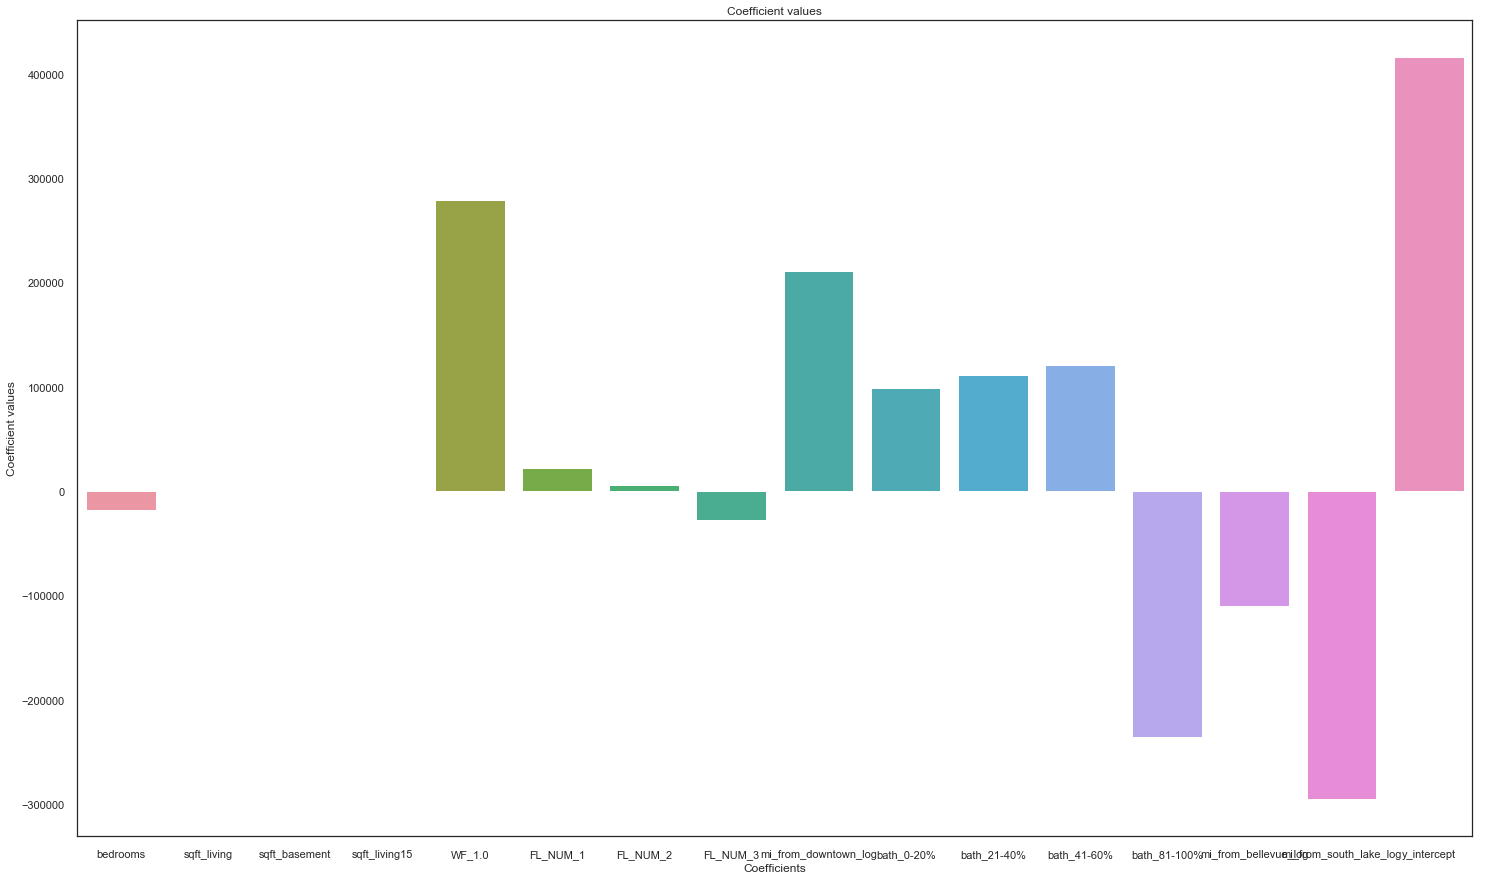

In [588]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
ax.set(xlabel='Coefficients', ylabel='Coefficient values')
ax.set_title('Coefficient values')
sns.barplot(labels, coef)

2. How location affects house prices?

Distances from Seattle downtown, Bellevue, South Lake Union appear to be among the strongest predictors of the price. Particularly, distance from South Lake Union which is the strongest predictor.